# **Notebook 4 : Fusion Multi-Modale**

Dans ce notebook, nous combinons les modèles CNN et RNN entraînés précédemment pour créer un modèle fusionné qui tire parti des informations visuelles et textuelles. Les étapes clés sont :

- **Chargement des Modèles Pré-entraînés :** Nous chargeons les modèles CNN et RNN sauvegardés précédemment.
- **Extraction des Caractéristiques :** Nous prenons les sorties intermédiaires des deux modèles (avant les couches de classification) comme représentations des images et des textes.
- **Fusion des Caractéristiques :** Nous concaténons les vecteurs de caractéristiques visuelles et textuelles pour créer une représentation combinée.
- **Ajout de Couches Fully Connected :** Nous ajoutons des couches supplémentaires pour apprendre les interactions entre les deux modalités.
- **Compilation et Entraînement du Modèle Fusionné :** Nous compilons le modèle avec la fonction de perte `binary_crossentropy` et entraînons sur les données combinées.
- **Utilisation de `tf.data.Dataset` :** Nous gérons efficacement les données multi-modales en utilisant des générateurs de données.
- **Sauvegarde du Modèle Fusionné :** Nous sauvegardons le modèle pour une utilisation ultérieure.

**Pourquoi ?**

La fusion multi-modale permet au modèle de tirer parti des informations complémentaires présentes dans les images et les textes. En combinant les deux sources de données, le modèle peut obtenir une compréhension plus riche et améliorer les performances de classification.


In [2]:
# Import des bibliothèques nécessaires
import os
import numpy as np
import pickle
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
# Chemins des données et des modèles
data_dir = "../datasets/flickr8k/"
model_dir = "../models/"

# Charger les données prétraitées
with open(os.path.join(data_dir, "train_data.pkl"), "rb") as f:
    train_data = pickle.load(f)

with open(os.path.join(data_dir, "test_data.pkl"), "rb") as f:
    test_data = pickle.load(f)

# Charger le tokenizer et les labels de classe
with open(os.path.join(data_dir, "tokenizer.pkl"), "rb") as f:
    tokenizer = pickle.load(f)

with open(os.path.join(data_dir, "class_labels.pkl"), "rb") as f:
    class_labels = pickle.load(f)

# Charger les modèles pré-entraînés
image_model = load_model(os.path.join(model_dir, "mobilenetv2_image_model.keras"))
text_model = load_model(os.path.join(model_dir, "text_model.keras"))

print("Modèles pré-entraînés chargés avec succès.")

Modèles pré-entraînés chargés avec succès.


In [4]:
# Paramètres globaux
IMG_SIZE = (224, 224)
MAX_SEQUENCE_LENGTH = 30  # Doit correspondre à la longueur utilisée précédemment
NUM_CLASSES = len(class_labels)
BATCH_SIZE = 32
BUFFER_SIZE = 1000  # Taille du buffer pour le shuffle

# Fonction pour charger et prétraiter une image
def load_and_preprocess_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Remplacez par decode_png si vos images sont en PNG
    img = tf.image.resize(img, IMG_SIZE)
    img = preprocess_input(img)
    return img

# Fonction pour prétraiter une séquence de texte
def preprocess_sequence(sequence):
    sequence = tf.cast(sequence, tf.int32)
    return sequence

# Créer le dataset
def create_dataset(data, batch_size, shuffle=True):
    img_paths, sequences, labels = zip(*data)
    img_paths = list(img_paths)
    sequences = list(sequences)
    labels = np.array(labels)

    dataset = tf.data.Dataset.from_tensor_slices((img_paths, sequences, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=BUFFER_SIZE)
    dataset = dataset.map(lambda img_path, seq, label: ((load_and_preprocess_image(img_path), preprocess_sequence(seq)), label),
                          num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(train_data, BATCH_SIZE, shuffle=True)
test_dataset = create_dataset(test_data, BATCH_SIZE, shuffle=False)

In [5]:
# Obtenir les sorties des modèles pré-entraînés sans les couches de classification finales
# Modèle d'image
image_input = image_model.input
image_output = image_model.layers[-3].output  # Sortie avant la dernière couche Dense

# Modèle de texte
text_input = text_model.input
text_output = text_model.layers[-3].output  # Sortie avant la dernière couche Dense

# Fusionner les deux sorties
combined = Concatenate()([image_output, text_output])

# Ajouter des couches fully connected
x = Dense(256, activation='relu')(combined)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

# Couche de sortie pour la classification multi-label
final_output = Dense(NUM_CLASSES, activation='sigmoid')(x)

# Créer le modèle fusionné
multi_modal_model = Model(inputs=[image_input, text_input], outputs=final_output)

# Compiler le modèle
multi_modal_model.compile(optimizer=Adam(learning_rate=0.0001),
                          loss='binary_crossentropy',
                          metrics=['binary_accuracy'])

# Afficher le résumé du modèle
multi_modal_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,341,074 (12.75 MB)

 Trainable params: 2,609,490 (9.95 MB)

 Non-trainable params: 731,584 (2.79 MB)

In [6]:
# Entraîner le modèle fusionné
EPOCHS = 10

history = multi_modal_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/10


c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer_9', 'input_layer_8']. Received: the structure of inputs=('*', '*')
  warnings.warn(


625/625 ━━━━━━━━━━━━━━━━━━━━ 272s 424ms/step - binary_accuracy: 0.7470 - loss: 0.5217 - val_binary_accuracy: 0.8309 - val_loss: 0.4034
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 294s 470ms/step - binary_accuracy: 0.8460 - loss: 0.3600 - val_binary_accuracy: 0.8498 - val_loss: 0.3511
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 291s 466ms/step - binary_accuracy: 0.8669 - loss: 0.3110 - val_binary_accuracy: 0.8548 - val_loss: 0.3433
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 282s 452ms/step - binary_accuracy: 0.8805 - loss: 0.2801 - val_binary_accuracy: 0.8504 - val_loss: 0.3540
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 274s 438ms/step - binary_accuracy: 0.8911 - loss: 0.2579 - val_binary_accuracy: 0.8538 - val_loss: 0.3488
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 274s 438ms/step - binary_accuracy: 0.8993 - loss: 0.2398 - val_binary_accuracy: 0.8537 - val_loss: 0.3476
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 271s 434ms/step - binary_accuracy: 0.9047 - loss: 0.2266 - val_binary_accuracy: 0.8529 - val_lo

In [7]:
# Évaluer le modèle sur l'ensemble de test
test_loss, test_binary_accuracy = multi_modal_model.evaluate(test_dataset)
print(f"Perte sur l'ensemble de test : {test_loss}")
print(f"Précision binaire sur l'ensemble de test : {test_binary_accuracy}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 43s 277ms/step - binary_accuracy: 0.8489 - loss: 0.3865
Perte sur l'ensemble de test : 0.3872285783290863
Précision binaire sur l'ensemble de test : 0.8488720655441284


In [8]:
# Sauvegarder le modèle fusionné
model_dir = "../models/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

multi_modal_model.save(os.path.join(model_dir, "multi_modal_model.keras"))

# Sauvegarder l'historique d'entraînement
with open(os.path.join(model_dir, "multi_modal_training_history.pkl"), "wb") as f:
    pickle.dump(history.history, f)

print("Modèle fusionné et historique d'entraînement sauvegardés.")

Modèle fusionné et historique d'entraînement sauvegardés.


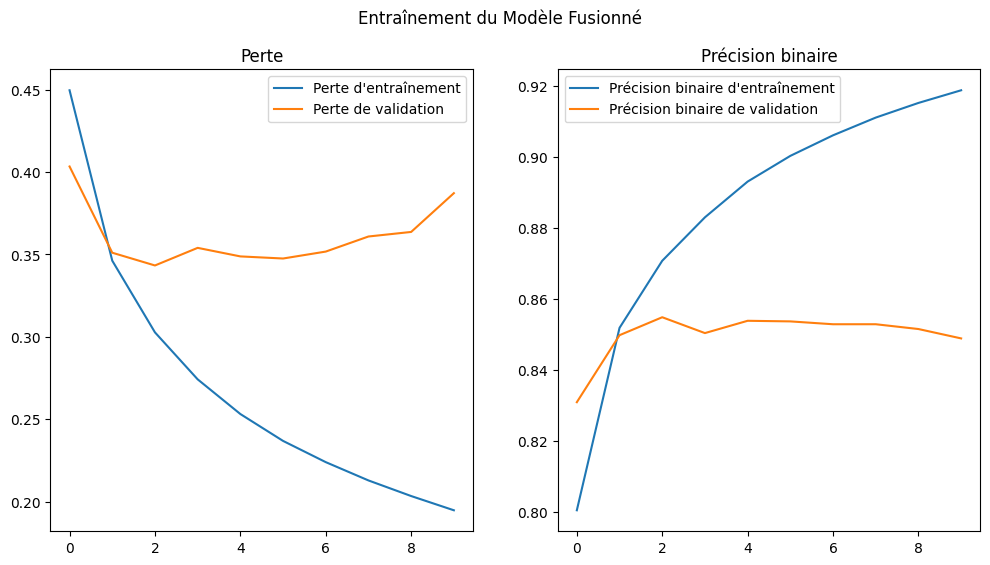

In [9]:
# Fonction pour plotter les résultats
def plot_training_history(history, title):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history["loss"], label="Perte d'entraînement")
    plt.plot(history["val_loss"], label="Perte de validation")
    plt.legend()
    plt.title("Perte")

    plt.subplot(1, 2, 2)
    plt.plot(history["binary_accuracy"], label="Précision binaire d'entraînement")
    plt.plot(history["val_binary_accuracy"], label="Précision binaire de validation")
    plt.legend()
    plt.title("Précision binaire")

    plt.suptitle(title)
    plt.show()

# Visualiser l'historique d'entraînement
plot_training_history(history.history, "Entraînement du Modèle Fusionné")